# 3.1 MNIST

In [59]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784',version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [60]:
X,y=mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

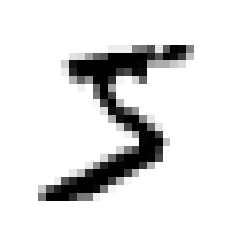

In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [62]:
y[0]

'5'

In [63]:
#숫자로 변형
import numpy as np
y=y.astype(np.uint8)

In [64]:
#훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test=X[:60000], X[:60000], y[:60000], y[:60000]

# 3.2 이진 분류기 훈련

In [65]:
#5만 분류 해보기

y_train_5=(y_train==5) # 5는 True이고, 다른 숫자는 모두 False
y_test_5=(y_test==5)

In [66]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [67]:
sgd_clf.predict([some_digit])

array([ True])

#3.3 성능 측정



## 3.3.1 교차 검증을 사용한 정확도 측정

In [68]:
#cross_val_score과 같은 성능을 실행하는 코드
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [69]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [70]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [71]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차 행렬

In [72]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [73]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [74]:
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 3.3.3 정밀도와 재현율

In [75]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [76]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [77]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 3.3.4 정밀도/재현율 트레이드오프

In [78]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [79]:
threshold=0
y_some_digit_pred=(y_scores>threshold)

y_some_digit_pred

array([ True])

In [80]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [81]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [82]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

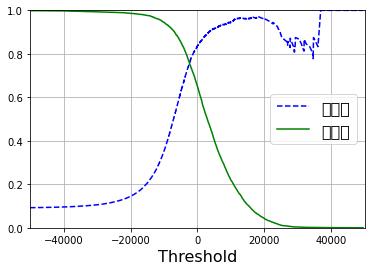

In [83]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='정밀도')
    plt.plot(thresholds, recalls[:-1], "g-", label='재현율')
    plt.legend()
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [84]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]

In [85]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [86]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [87]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선

In [88]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds=roc_curve(y_train_5, y_scores)

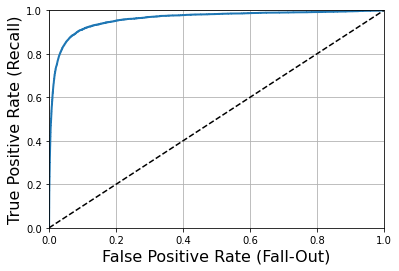

In [89]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)   

plot_roc_curve(fpr, tpr)
plt.show()

In [90]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [91]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [92]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

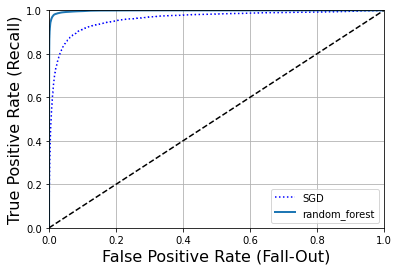

In [93]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'random_forest')
plt.legend(loc='lower right')
plt.show()

In [94]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중 분류

In [95]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [96]:
some_digit_score=svm_clf.decision_function([some_digit])
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [97]:
np.argmax(some_digit_score)

5

In [98]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [99]:
svm_clf.classes_[5]

5

In [100]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [101]:
len(ovr_clf.estimators_)

10

In [102]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [103]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [104]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [105]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

#3.5 에러분석

In [106]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

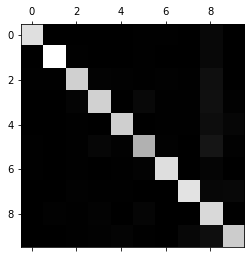

In [107]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [108]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

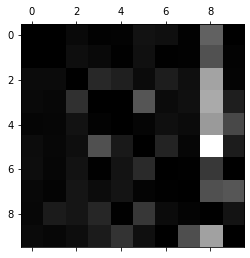

In [109]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [110]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

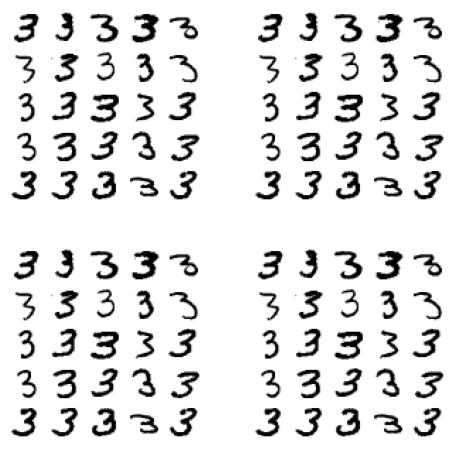

In [111]:
cl_a, cl_b=3,5

X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_aa[:25], images_per_row=5)

plt.show()

# 3.6 다중 레이블 분류

In [112]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train % 2 == 1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [113]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [114]:
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# 3.7 다중 출력 분류

In [115]:
noise=np.random.randint(0,100,(len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

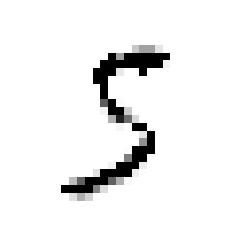

In [117]:
some_index=0

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)